In [ ]:
# Link Data
  # https://github.com/owid/covid-19-data/blob/master/public/data/README.md

# Install and import libraries

In [ ]:
!pip install pmdarima     # dòng này để cài Arima, thuật toán nằm trong bài toán time series 

     |████████████████████████████████| 1.5MB 13.1MB/s 
     |████████████████████████████████| 9.5MB 49.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# --------------------------------------------------------  đừng care mấy cái libs này, a thêm chơi cho vui thôi :))      -----------------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support # Cái này sẽ dùng để đánh giá model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA  
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori, association_rules  
from mlxtend.preprocessing import TransactionEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import svm
from scipy.integrate import odeint
import xgboost as xgb
from wordcloud import WordCloud,STOPWORDS
# ----------------------------------------------------------  Cái đống này là dùng để build model, task 3 a sẽ dùng, nên cứ add trước cho khỏe :3 ------------------------------------------

import os, sys, glob, datetime, warnings
from google.colab import files, drive
warnings.filterwarnings("ignore")
%matplotlib inline

# Load data

In [ ]:
#load data      # đừng chạy dòng này, a đã upload cả 2 file data lên r nên k cần chạy lại nữa
#uploaded = files.upload()

In [ ]:
df_new = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv",  parse_dates=['date'], index_col='date')
df_new.tail()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-02,ZWE,Africa,Zimbabwe,52663.0,1442.0,1063.714,1841.0,33.0,17.143,3543.246,97.020,71.568,123.865,2.220,1.153,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1352718.0,788004.0,564714.0,10758.0,18686.0,9.10,5.30,3.80,1257.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
2021-07-03,ZWE,Africa,Zimbabwe,53665.0,1002.0,1092.429,1859.0,18.0,19.143,3610.662,67.416,73.500,125.076,1.211,1.288,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1359587.0,791901.0,567686.0,6869.0,15726.0,9.15,5.33,3.82,1058.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
2021-07-04,ZWE,Africa,Zimbabwe,54474.0,809.0,1147.429,1878.0,19.0,20.286,3665.092,54.431,77.201,126.355,1.278,1.365,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1361210.0,793077.0,568133.0,1623.0,12279.0,9.16,5.34,3.82,826.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
2021-07-05,ZWE,Africa,Zimbabwe,56014.0,1540.0,1247.143,1911.0,33.0,23.143,3768.706,103.614,83.910,128.575,2.220,1.557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1369436.0,797715.0,571721.0,8226.0,10040.0,9.21,5.37,3.85,676.0,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
2021-07-06,ZWE,Africa,Zimbabwe,57963.0,1949.0,1347.143,1939.0,28.0,25.429,3899.837,131.132,90.638,130.459,1.884,1.711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN




*   Giữ lại 1 số cột cần thiết (có thể tùy biến)





In [ ]:
df = df_new[["continent", "location", "population", "total_cases", "new_cases", "new_cases_smoothed", "total_deaths", "new_deaths", "new_deaths_smoothed", "total_tests", "new_tests", "positive_rate"]]
df.tail()

,continent,location,population,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_tests,new_tests,positive_rate
date,,,,,,,,,,,,
2021-07-02,Africa,Zimbabwe,14862927.0,52663.0,1442.0,1063.714,1841.0,33.0,17.143,NaN,NaN,NaN
2021-07-03,Africa,Zimbabwe,14862927.0,53665.0,1002.0,1092.429,1859.0,18.0,19.143,NaN,NaN,NaN
2021-07-04,Africa,Zimbabwe,14862927.0,54474.0,809.0,1147.429,1878.0,19.0,20.286,NaN,NaN,NaN
2021-07-05,Africa,Zimbabwe,14862927.0,56014.0,1540.0,1247.143,1911.0,33.0,23.143,NaN,NaN,NaN
2021-07-06,Africa,Zimbabwe,14862927.0,57963.0,1949.0,1347.143,1939.0,28.0,25.429,NaN,NaN,NaN


In [ ]:
df.describe()

,population,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_tests,new_tests,positive_rate
count,1.000270e+05,9.698600e+04,96983.000000,95973.000000,8.681900e+04,86975.000000,95973.000000,4.480500e+04,4.512800e+04,49044.000000
mean,1.246065e+08,1.082811e+06,6038.570131,6064.040301,2.918689e+04,146.249807,131.818162,7.931971e+06,4.892982e+04,0.088467
std,6.796614e+08,7.405372e+06,37719.529189,37469.233714,1.741888e+05,800.027821,743.942061,3.449752e+07,2.151741e+05,0.097155
min,4.700000e+01,1.000000e+00,-74347.000000,-6223.000000,1.000000e+00,-1918.000000,-232.143000,0.000000e+00,-2.391720e+05,0.000000
25%,2.225728e+06,1.299250e+03,2.000000,7.571000,5.500000e+01,0.000000,0.000000,1.644320e+05,1.671750e+03,0.016000
50%,9.890400e+06,1.372750e+04,74.000000,92.429000,4.030000e+02,2.000000,1.429000,8.409900e+05,6.247000e+03,0.053000
75%,3.481387e+07,1.467095e+05,812.000000,854.714000,3.879500e+03,18.000000,14.571000,3.523638e+06,2.408075e+04,0.128000
max,7.794799e+09,1.846120e+08,906017.000000,826388.429000,3.993160e+06,18050.000000,14737.000000,4.699611e+08,2.600460e+07,0.933000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100446 entries, 2020-02-24 to 2021-07-05
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   continent            95741 non-null   object 
 1   location             100446 non-null  object 
 2   population           99797 non-null   float64
 3   total_cases          96785 non-null   float64
 4   new_cases            96782 non-null   float64
 5   new_cases_smoothed   95772 non-null   float64
 6   total_deaths         86625 non-null   float64
 7   new_deaths           86781 non-null   float64
 8   new_deaths_smoothed  95772 non-null   float64
 9   total_tests          44787 non-null   float64
 10  new_tests            45118 non-null   float64
 11  positive_rate        49044 non-null   float64
dtypes: float64(10), object(2)
memory usage: 10.0+ MB


# Build model


## USA

In [ ]:
new_cases_USA = df["new_cases"].where(df["location"] == "United States").dropna()
total_cases_USA = df["total_cases"].where(df["location"] == "United States").dropna()
new_cases_USA_smoothed = df["new_cases_smoothed"].where(df["location"] == "United States").dropna()

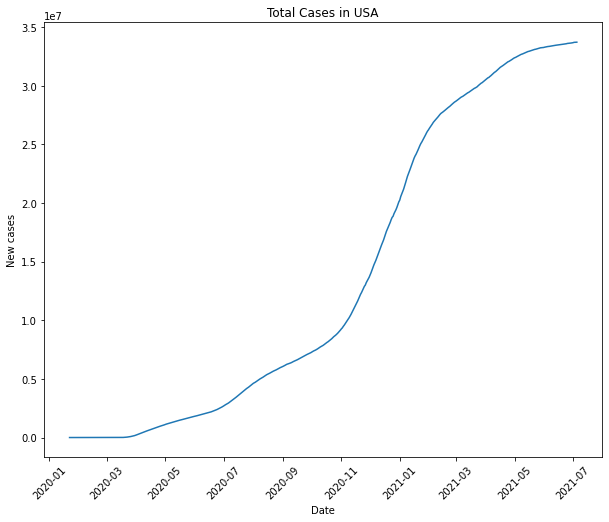

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Total Cases in USA")
plt.plot(total_cases_USA)
plt.xlabel('Date')
plt.ylabel('New cases')
plt.xticks(rotation=45)
plt.show()

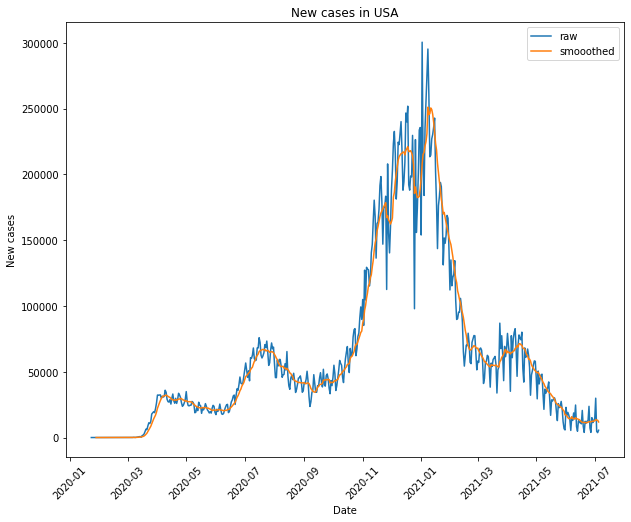

In [ ]:
plt.figure(figsize=(10,8))
plt.title("New cases in USA")
plt.plot(new_cases_USA, label="raw")
plt.plot(new_cases_USA_smoothed, label="smooothed")
plt.xlabel('Date')
plt.ylabel('New cases')
plt.xticks(rotation=45)
plt.legend()
plt.show()

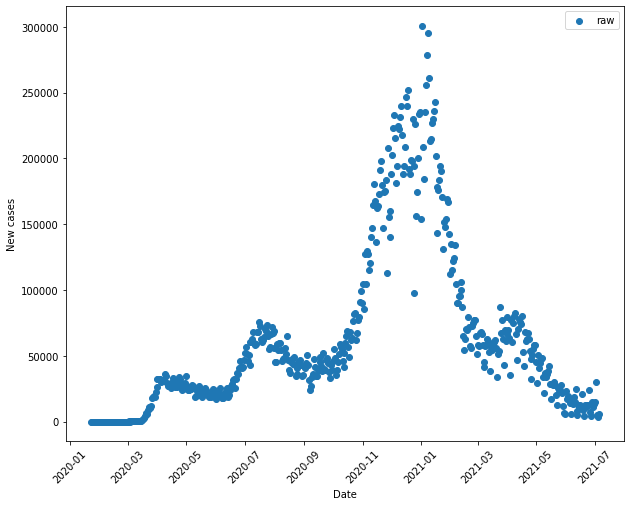

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(new_cases_USA.index, new_cases_USA.values, label="raw")
#plt.scatter(new_cases_USA_smoothed.index, new_cases_USA_smoothed.values, label="smooothed")
plt.xlabel('Date')
plt.ylabel('New cases')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Evaluate:
- The number of new Covid-19 infections increased sharply from the beginning of 2020 until January 2021, then dropped sharply.
- Expected time is from 1 week to 12 weeks (3 months)  
    + For 1 week: can get data from January to May or June to train because the trend is falling sharply 
    + for 3 months: to predict properly is....... impossible :)
- Divide data according to the ratio of 80% train and 20% test (or 70%-30%, 75%-25%...) 

In [ ]:
#Select Time to train
start_time = '2021-02-01'
end_time = '2021-06-01'
# start_time->end_time (train),  End_time -> now (test)

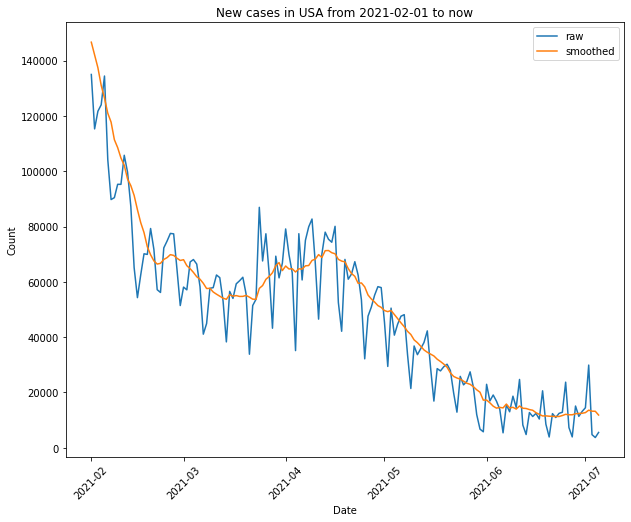

In [ ]:
plt.figure(figsize=(10,8))
plt.title("New cases in USA from " + start_time + " to now")
plt.plot(new_cases_USA[start_time:], label="raw")                                                         
plt.plot(new_cases_USA_smoothed[start_time:], label="smoothed")
plt.ylabel("Count")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()

In [ ]:
result = seasonal_decompose(new_cases_USA[start_time:], model='multiplicative')    
result_add = seasonal_decompose(new_cases_USA[start_time:], model='additional')
result

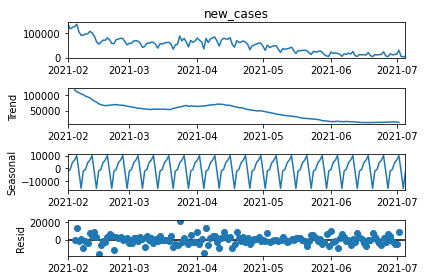

In [ ]:
result_add.plot()
plt.show()

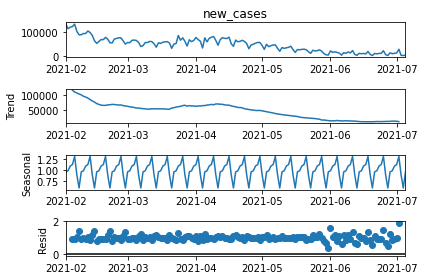

In [ ]:
result.plot()
plt.show()

Text(0.5, 1.0, 'Multiplicative seasonal decomposition trend')

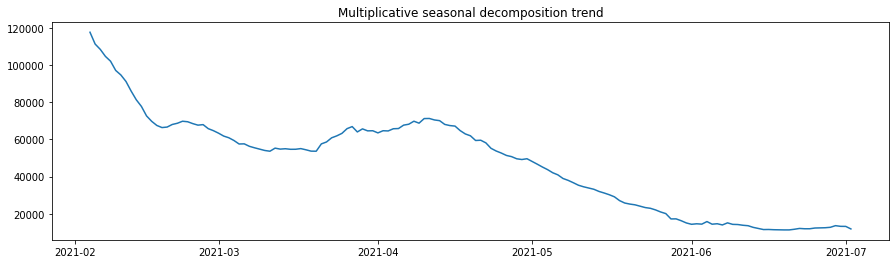

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result.trend)
plt.title("Multiplicative seasonal decomposition trend") 

Text(0.5, 1.0, 'Seasonality verification')

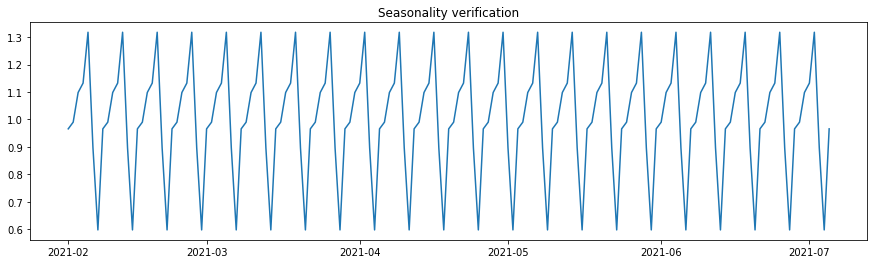

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result.seasonal)
plt.title("Seasonality verification")  

 - Data is seasonal

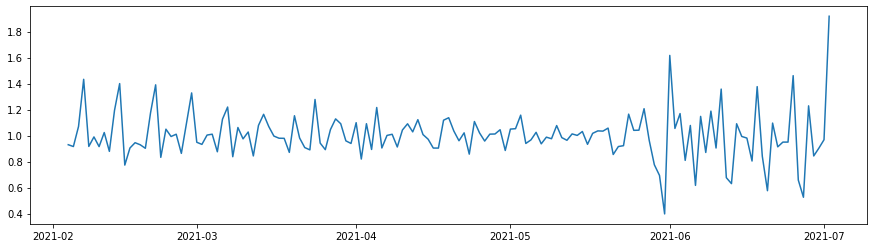

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result.resid) 

- Relative data fluctuations, with some anomalies (6/2021) 

### Train - Test Split

In [ ]:
train_USA = new_cases_USA.loc[start_time:end_time]  # train & test split
test_USA = new_cases_USA.loc[end_time:]

In [ ]:
print("Train length: ", len(train_USA))
print("Test length: ",len(test_USA))
print("Ratio: ", (len(test_USA))/ (len(test_USA)+len(train_USA)))  

Train length:  121
Test length:  35
Ratio:  0.22435897435897437


### ARIMA MODEL

In [ ]:
stepwise_model = auto_arima(new_cases_USA[start_time:], start_p=2, start_q=2,
                            max_p=5, max_q=5, m=7, seasonal=True,
                            d=None, D=None, trace=True,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3274.938, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3327.137, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3278.657, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3287.669, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3325.928, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=3288.510, Time=0.44 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=3272.398, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=3275.795, Time=0.89 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=3273.314, Time=0.81 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=3264.945, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=3261.400, Time=0.47 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=3257.659, Time=0.79 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=3

- Select parameters for the model, use the aic index to find the best parameters for the model, the lower the aic -> the more suitable parameters 

In [ ]:
stepwise_model.aic()

3220.944389507117

In [ ]:
stepwise_model.fit(train_USA)

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 2, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
future_forcast_USA = stepwise_model.predict(n_periods=len(test_USA)) 
future_forcast_USA

array([23690.4077274 , 28252.21929653, 26912.34745156, 19708.77312641,
        7365.04582114, 21706.43017478, 23087.91670742, 27686.01817556,
       29023.24942541, 30050.93948791, 20654.1529376 ,  9172.01245322,
       23204.95978624, 23973.74718393, 27201.84643679, 29399.39108892,
       29130.89088879, 20572.29833918,  8066.68447512, 22726.83110618,
       22587.07009691, 26410.32402863, 27837.96293165, 28104.59776796,
       18950.83803494,  6972.31153648, 21022.06566243, 21286.32075211,
       24637.41445119, 26407.22048223, 26289.84103868, 17483.7271336 ,
        5241.37848265, 19481.49867638, 19470.38944559])

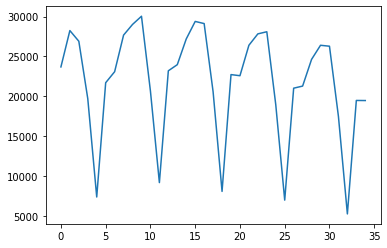

In [ ]:
plt.plot(future_forcast_USA)

In [ ]:
future_forcast_USA_dataframe = pd.DataFrame(future_forcast_USA, index= test_USA.index, columns=['Prediction'])
future_forcast_USA_dataframe.head()

,Prediction
date,
2021-06-01,23690.407727
2021-06-02,28252.219297
2021-06-03,26912.347452
2021-06-04,19708.773126
2021-06-05,7365.045821


In [ ]:
mae_USA = mean_absolute_error(test_USA, future_forcast_USA_dataframe[0:len(test_USA)])
mse_USA = mean_squared_error(test_USA, future_forcast_USA_dataframe[0:len(test_USA)])
print("Mean absolute error: ", mae_USA)
print("Mean squared error: ", mse_USA)
print("Root mean squared error: ", np.sqrt(mse_USA))

Mean absolute error:  10434.114458725022
Mean squared error:  146233399.64078322
Root mean squared error:  12092.700262587476


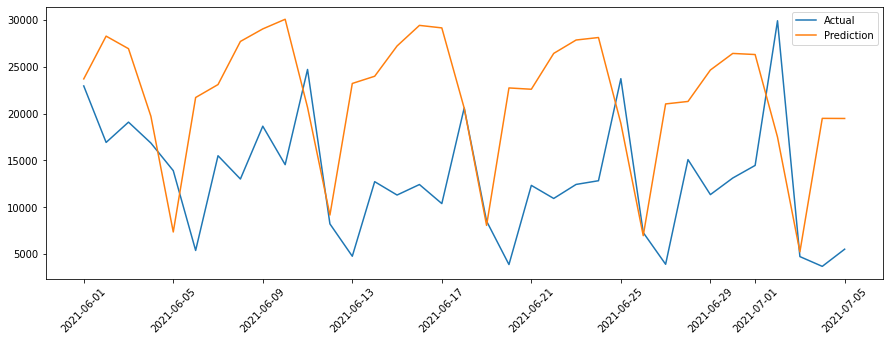

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_USA, label="Actual")
plt.plot(future_forcast_USA_dataframe, label="Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:

start_time_future_arima = datetime.datetime(2021,6, 23) #2021,6, 22
end_time_future_arima = datetime.datetime(2021, 7, 23)  #2021, 6, 29
start_end_index = pd.date_range(start=start_time_future_arima,end=end_time_future_arima)
pred_next_N_days_Arima = stepwise_model.predict(len(start_end_index))
pred_N_days_Arima = pd.DataFrame(pred_next_N_days_Arima, index= start_end_index, columns=['Prediction'])
print(pred_N_days_Arima)

              Prediction
2021-06-23  23690.407727
2021-06-24  28252.219297
2021-06-25  26912.347452
2021-06-26  19708.773126
2021-06-27   7365.045821
2021-06-28  21706.430175
2021-06-29  23087.916707
2021-06-30  27686.018176
2021-07-01  29023.249425
2021-07-02  30050.939488
2021-07-03  20654.152938
2021-07-04   9172.012453
2021-07-05  23204.959786
2021-07-06  23973.747184
2021-07-07  27201.846437
2021-07-08  29399.391089
2021-07-09  29130.890889
2021-07-10  20572.298339
2021-07-11   8066.684475
2021-07-12  22726.831106
2021-07-13  22587.070097
2021-07-14  26410.324029
2021-07-15  27837.962932
2021-07-16  28104.597768
2021-07-17  18950.838035
2021-07-18   6972.311536
2021-07-19  21022.065662
2021-07-20  21286.320752
2021-07-21  24637.414451
2021-07-22  26407.220482
2021-07-23  26289.841039


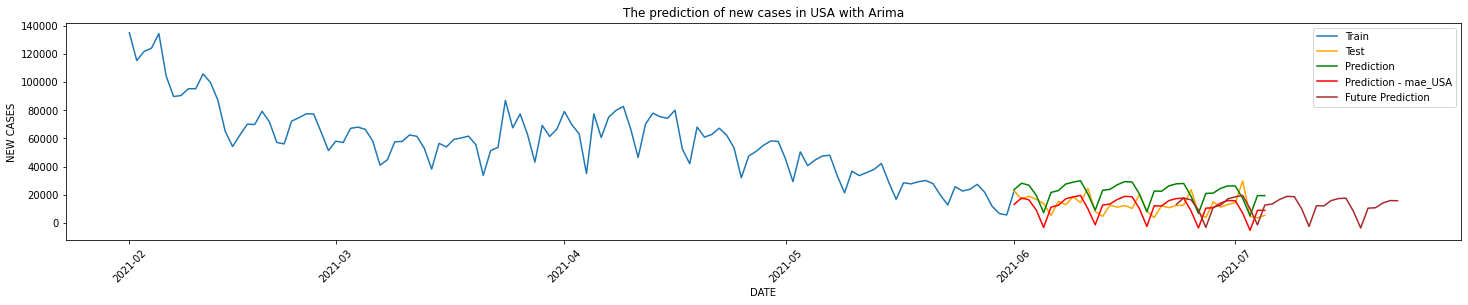

In [ ]:
plt.figure(figsize=(25,4))
plt.title("The prediction of new cases in USA with Arima")
plt.plot(new_cases_USA[start_time:end_time], label="Train")
plt.plot(new_cases_USA[end_time:], label="Test", color="orange")
plt.plot(future_forcast_USA_dataframe, label="Prediction", color="green")
plt.plot(future_forcast_USA_dataframe - mae_USA, label="Prediction - mae_USA", color="red")
plt.plot(pred_N_days_Arima - mae_USA, label="Future Prediction", color="brown")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.xticks(rotation=45)
plt.legend()
plt.show()

- Based on personal experience to adjust data prediction accordingly, for example: + or - mae to return data predict to the appropriate values

### HOLT WINTERS MODEL

#### Using Additive Seasonality

In [ ]:
HoltWinter_model_add = ExponentialSmoothing(train_USA, seasonal='add', seasonal_periods=7).fit()
pred_add = HoltWinter_model_add.predict(start=test_USA.index[0], end= test_USA.index[-1])

In [ ]:
mae_USA_add_hw = mean_absolute_error(test_USA, pred_add[0:len(test_USA)])
mse_USA_add_hw = mean_squared_error(test_USA, pred_add[0:len(test_USA)])
print("MAE: ", mae_USA_add_hw)
print("MSE: ",mse_USA_add_hw)

MAE:  4304.811070300243
MSE:  27111198.866995115


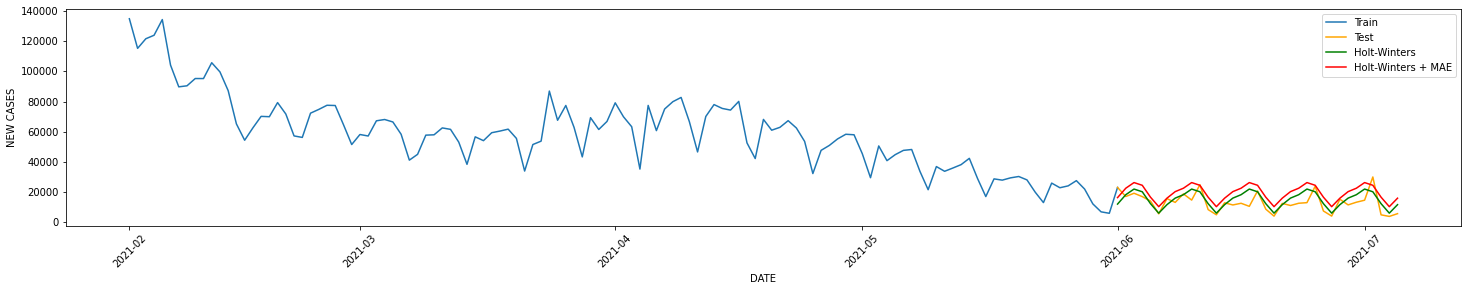

In [ ]:
plt.figure(figsize=(25,4))
plt.plot(train_USA.index, train_USA, label='Train')
plt.plot(test_USA.index, test_USA, color='orange', label='Test')
plt.plot(pred_add.index, pred_add, color='green', label='Holt-Winters')
plt.plot(pred_add.index, pred_add + mae_USA_add_hw, color='red', label='Holt-Winters + MAE')
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show()

#### Using Multiplicative Seasonality 

In [ ]:
HoltWinter_model_mul = ExponentialSmoothing(train_USA, seasonal='mul', seasonal_periods=7).fit()

pred_mul = HoltWinter_model_mul.predict(start=test_USA.index[0], end= test_USA.index[-1])

In [ ]:
mae_USA_mul_hw = mean_absolute_error(test_USA, pred_mul[0:len(test_USA)])
mse_USA_mul_hw = mean_squared_error(test_USA, pred_mul[0:len(test_USA)])
print("MAE: ", mae_USA_mul_hw)
print("MSE: ",mse_USA_mul_hw)

MAE:  4437.591194652889
MSE:  27931328.29272737


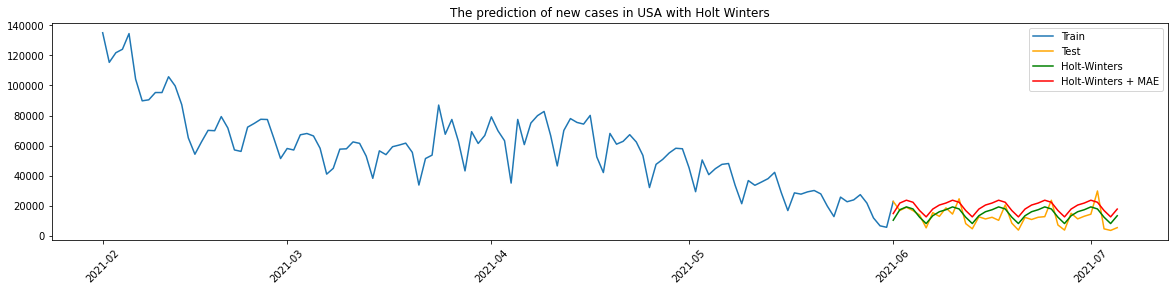

In [ ]:
plt.figure(figsize=(20,4))
plt.title("The prediction of new cases in USA with Holt Winters")
plt.plot(train_USA.index, train_USA, label='Train')
plt.plot(test_USA.index, test_USA, color='orange', label='Test')
plt.plot(pred_mul.index, pred_mul, color='green', label='Holt-Winters')
plt.plot(pred_mul.index, pred_mul + mae_USA_mul_hw, color='red', label='Holt-Winters + MAE')
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show()

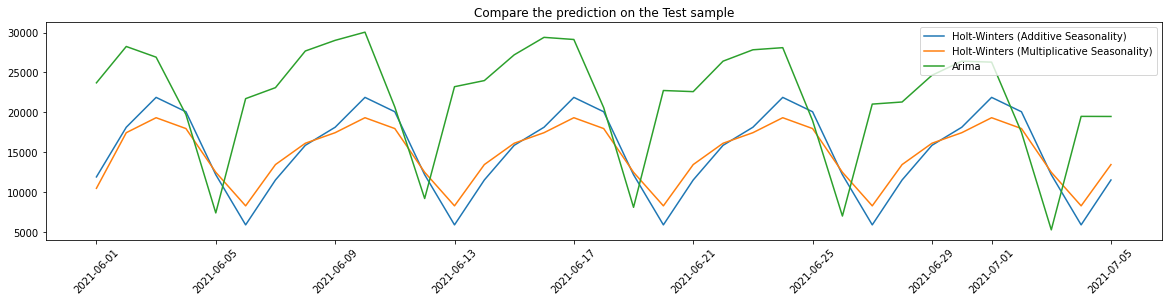

In [ ]:
plt.figure(figsize=(20,4))
plt.title("Compare the prediction on the Test sample")
plt.plot(pred_add, label="Holt-Winters (Additive Seasonality) ")
plt.plot(pred_mul, label="Holt-Winters (Multiplicative Seasonality)")
plt.plot(future_forcast_USA_dataframe, label="Arima")
plt.legend(loc="best")
plt.legend()
plt.xticks(rotation=45)
plt.show()

- Nhận xét: Arima đặt datetime sớm 1 ngày (tùy vào kinh nghiệm cá nhân để chỉnh sửa cho phù hợp), mức độ chênh lệch lớn hơn so với Holt Winters

### PREDICT FUTURE

In [ ]:
test_USA.index

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
               '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
               '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
               '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
               '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-03', '2021-07-04', '2021-07-05'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
#SELECT TIME TO PREDICT
start_time_future = datetime.datetime(2021,6, 22) #2021,6, 22
end_time_future = datetime.datetime(2021, 7, 22)  #2021, 6, 29
pred_next_N_days_add = HoltWinter_model_add.predict(start=start_time_future, end=end_time_future)
pred_next_N_days_mul = HoltWinter_model_mul.predict(start=start_time_future, end=end_time_future)
#pred_N_add = pd.Series(pred_next_7_days_add)
#pred_N_mul = pd.Series(pred_next_7_days_mul)

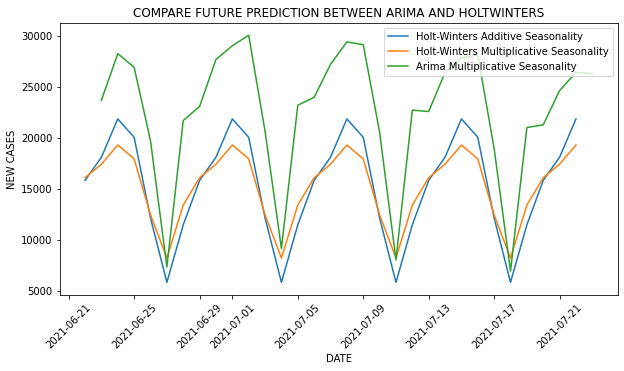

In [ ]:
plt.figure(figsize=(10,5))
plt.title("COMPARE FUTURE PREDICTION BETWEEN ARIMA AND HOLTWINTERS")
plt.plot(pred_next_N_days_add, label="Holt-Winters Additive Seasonality")
plt.plot(pred_next_N_days_mul, label="Holt-Winters Multiplicative Seasonality")
plt.plot(pred_N_days_Arima, label="Arima Multiplicative Seasonality")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend()
plt.xticks(rotation=45)
plt.show()

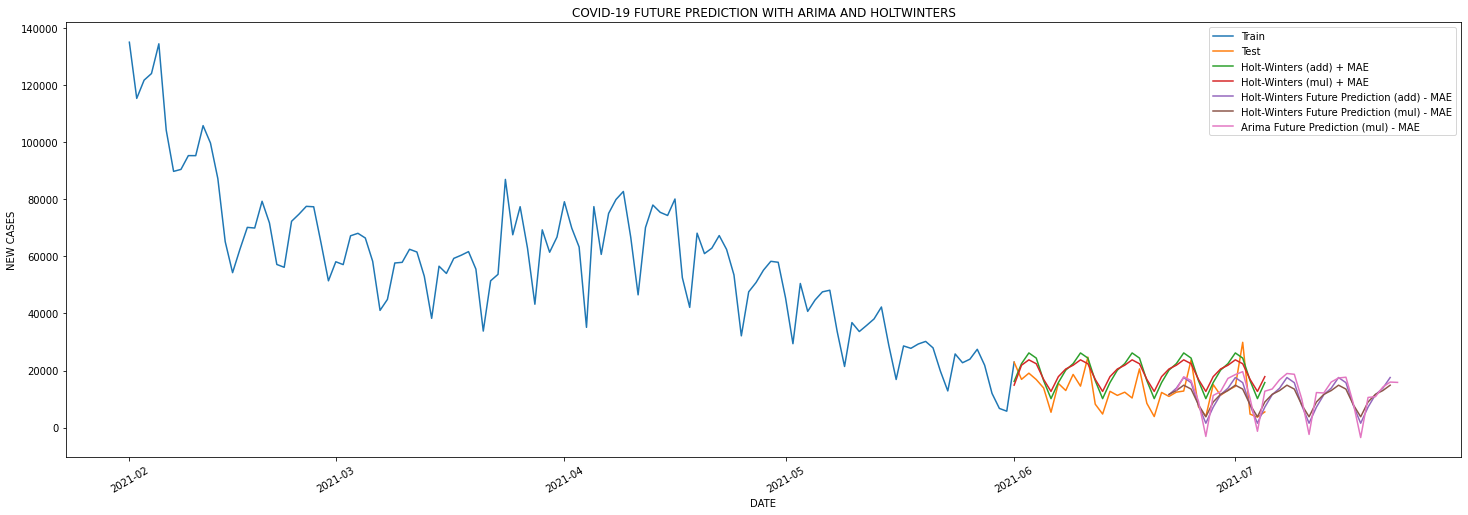

In [ ]:
plt.figure(figsize=(25,8))
plt.title("COVID-19 FUTURE PREDICTION WITH ARIMA AND HOLTWINTERS")
plt.plot(train_USA.index, train_USA, label='Train')
plt.plot(test_USA.index, test_USA, label='Test')
plt.plot(pred_add.index, pred_add + mae_USA_add_hw,  label='Holt-Winters (add) + MAE')
plt.plot(pred_mul.index, pred_mul + mae_USA_mul_hw,  label='Holt-Winters (mul) + MAE')
plt.plot(pred_next_N_days_add.index, pred_next_N_days_add.values  - mae_USA_add_hw, label="Holt-Winters Future Prediction (add) - MAE")
plt.plot(pred_next_N_days_mul.index, pred_next_N_days_mul.values  - mae_USA_mul_hw, label="Holt-Winters Future Prediction (mul) - MAE")
plt.plot(pred_N_days_Arima - mae_USA, label="Arima Future Prediction (mul) - MAE")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend(loc="best")
plt.xticks(rotation=30)
plt.show()

Conclusion: Both Arima and Holt-Winter models give good prediction in SHORT TERM (from 1 week - 1 month), if the prediction time is longer, need to retrain with a larger amount of data for best prediction and the possibility of error is very large. 

## World

In [ ]:
df_world = df[["continent","new_cases", "new_cases_smoothed"]].dropna()
df_world = df_world.groupby('date')[['new_cases','new_cases_smoothed']].sum()
df_world.head()

,new_cases,new_cases_smoothed
date,,
2020-01-28,2646.0,714.143
2020-01-29,580.0,797.572
2020-01-30,2063.0,1079.430
2020-01-31,1685.0,1280.859
2020-02-01,2109.0,1512.856


In [ ]:
new_cases_World = df_world['new_cases']
new_cases_World_smoothed = df_world['new_cases_smoothed']

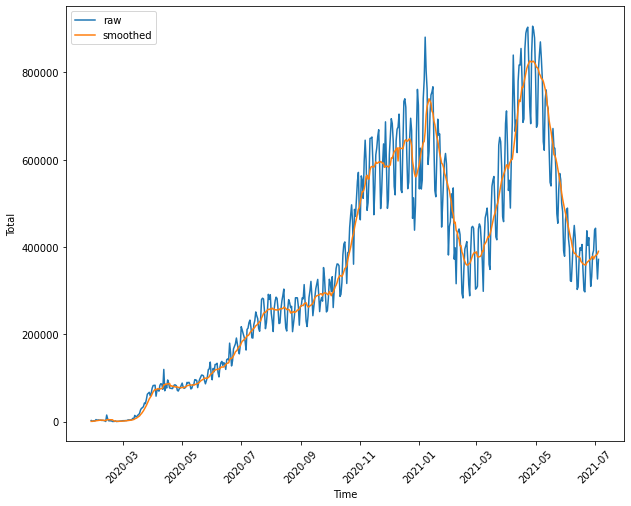

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(new_cases_World, label="raw")
plt.plot(new_cases_World_smoothed, label="smoothed")
plt.xlabel('Time')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.legend()

In [ ]:
#SELECT TIME
start_time_world = '2021-02-01'
end_time_world = '2021-06-01'

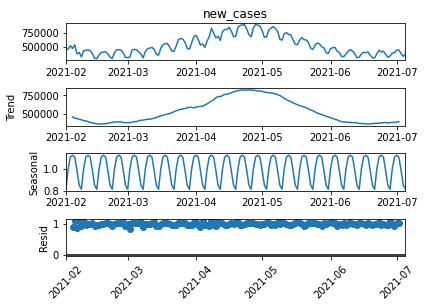

--------------------------------------------------------------------------------


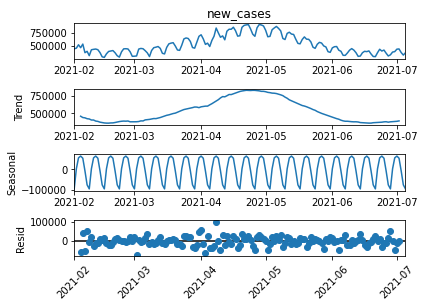

In [ ]:
result_add = seasonal_decompose(new_cases_World[start_time_world:],model='additive')
result_mul = seasonal_decompose(new_cases_World[start_time_world:],model='multiplicative')
result_mul.plot()
plt.xticks(rotation=45)
plt.show()
print('-'*80)
result_add.plot()
plt.xticks(rotation=45)
plt.show()

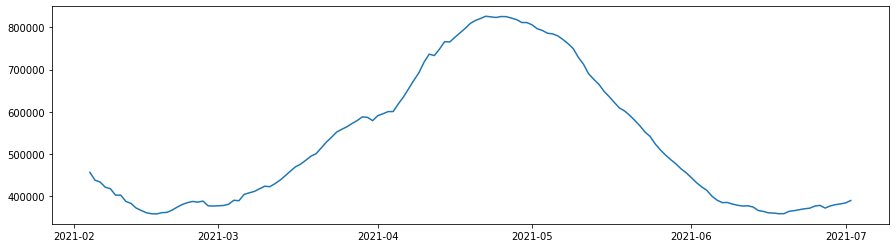

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result_mul.trend)

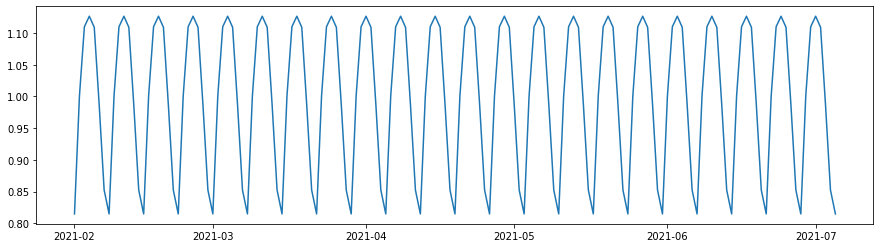

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result_mul.seasonal)

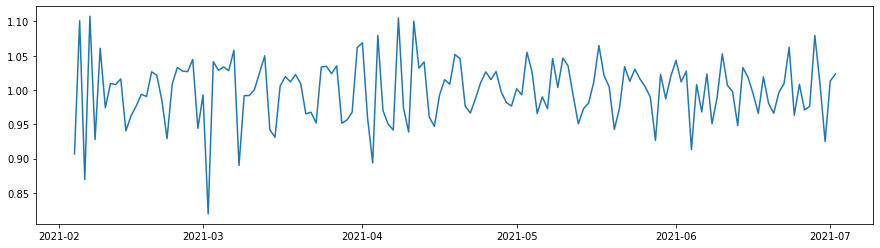

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(result_mul.resid)

### Train - Test split

In [ ]:
train_World = new_cases_World.loc[start_time_world:end_time_world]  # train & test split
test_World = new_cases_World.loc[end_time_world:]
print("Train length: ", len(train_World))
print("Test length: ",len(test_World))
print("Ratio: ", (len(test_World))/ (len(test_World)+len(train_World)))  

Train length:  121
Test length:  35
Ratio:  0.22435897435897437


### Build Holt Winters Model

In [ ]:
HoltWinter_model_mul_World = ExponentialSmoothing(train_World, seasonal='mul', seasonal_periods=7).fit()
HoltWinter_model_add_World = ExponentialSmoothing(train_World, seasonal='add', seasonal_periods=7).fit()
pred_mul_World = HoltWinter_model_mul_World.predict(start=test_World.index[0], end= test_World.index[-1])
pred_add_World = HoltWinter_model_add_World.predict(start=test_World.index[0], end= test_World.index[-1])

In [ ]:
mae_World_mul_hw = mean_absolute_error(test_World, pred_mul_World[0:len(test_World)])
mse_World_mul_hw = mean_squared_error(test_World, pred_mul_World[0:len(test_World)])
mae_World_add_hw = mean_absolute_error(test_World, pred_add_World[0:len(test_World)])
mse_World_add_hw = mean_squared_error(test_World, pred_add_World[0:len(test_World)])
print("MAE Mul:  ", mae_World_mul_hw)
print("MSE Mull: ",mse_World_mul_hw)
print("MAE Add:  ", mae_World_add_hw)
print("MSE Add:  ", mse_World_add_hw)

MAE Mul:   67977.29494813722
MSE Mull:  5441523600.405334
MAE Add:   83354.22253152927
MSE Add:   7975240889.718609


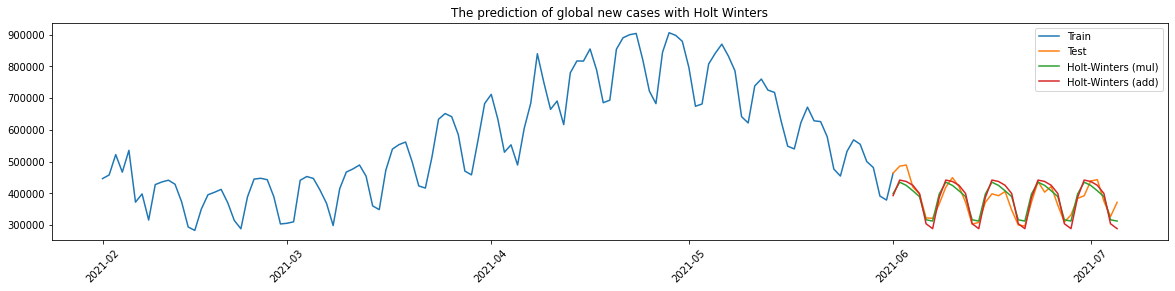

In [ ]:
plt.figure(figsize=(20,4))
plt.title("The prediction of global new cases with Holt Winters")
plt.plot(train_World.index, train_World, label='Train')
plt.plot(test_World.index, test_World, label='Test')
plt.plot(pred_mul_World.index, pred_mul_World - mae_World_mul_hw, label='Holt-Winters (mul)')
plt.plot(pred_add_World.index, pred_add_World - mae_World_add_hw, label='Holt-Winters (add)')
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show()

### Future Predict

In [ ]:
test_World

date
2021-06-01    463722.0
2021-06-02    485707.0
2021-06-03    489217.0
2021-06-04    419795.0
2021-06-05    398267.0
2021-06-06    322691.0
2021-06-07    321305.0
2021-06-08    366820.0
2021-06-09    419492.0
2021-06-10    449506.0
2021-06-11    421253.0
2021-06-12    371903.0
2021-06-13    302918.0
2021-06-14    308518.0
2021-06-15    371501.0
2021-06-16    398534.0
2021-06-17    392496.0
2021-06-18    405931.0
2021-06-19    347446.0
2021-06-20    300324.0
2021-06-21    297341.0
2021-06-22    372137.0
2021-06-23    437255.0
2021-06-24    403837.0
2021-06-25    421740.0
2021-06-26    362819.0
2021-06-27    309889.0
2021-06-28    331949.0
2021-06-29    384156.0
2021-06-30    392429.0
2021-07-01    439059.0
2021-07-02    443141.0
2021-07-03    375056.0
2021-07-04    326855.0
2021-07-05    371772.0
Name: new_cases, dtype: float64

In [ ]:
#SELECT TIME TO PREDICT
start_time_future = datetime.datetime(2021,7, 5) #2021,6, 22
end_time_future = datetime.datetime(2021, 7, 22)  #2021, 6, 29
pred_next_N_days_add_World = HoltWinter_model_add_World.predict(start=start_time_future, end=end_time_future)
pred_next_N_days_mul_World = HoltWinter_model_mul_World.predict(start=start_time_future, end=end_time_future)
pred_N_add_World = pd.Series(pred_next_N_days_add_World)
pred_N_mul_World = pd.Series(pred_next_N_days_mul_World)

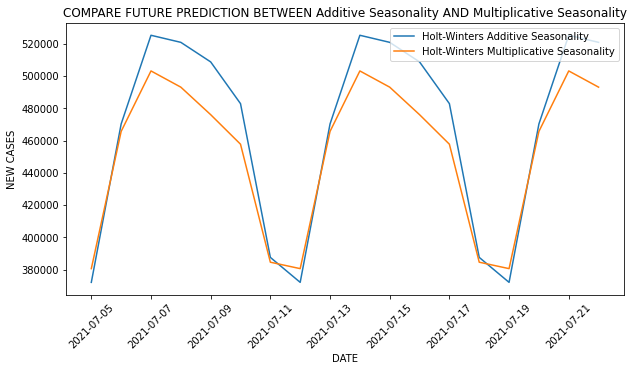

In [ ]:
plt.figure(figsize=(10,5))
plt.title("COMPARE FUTURE PREDICTION BETWEEN Additive Seasonality AND Multiplicative Seasonality")
plt.plot(pred_next_N_days_add_World, label="Holt-Winters Additive Seasonality")
plt.plot(pred_next_N_days_mul_World, label="Holt-Winters Multiplicative Seasonality")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend()
plt.xticks(rotation=45)
plt.show()

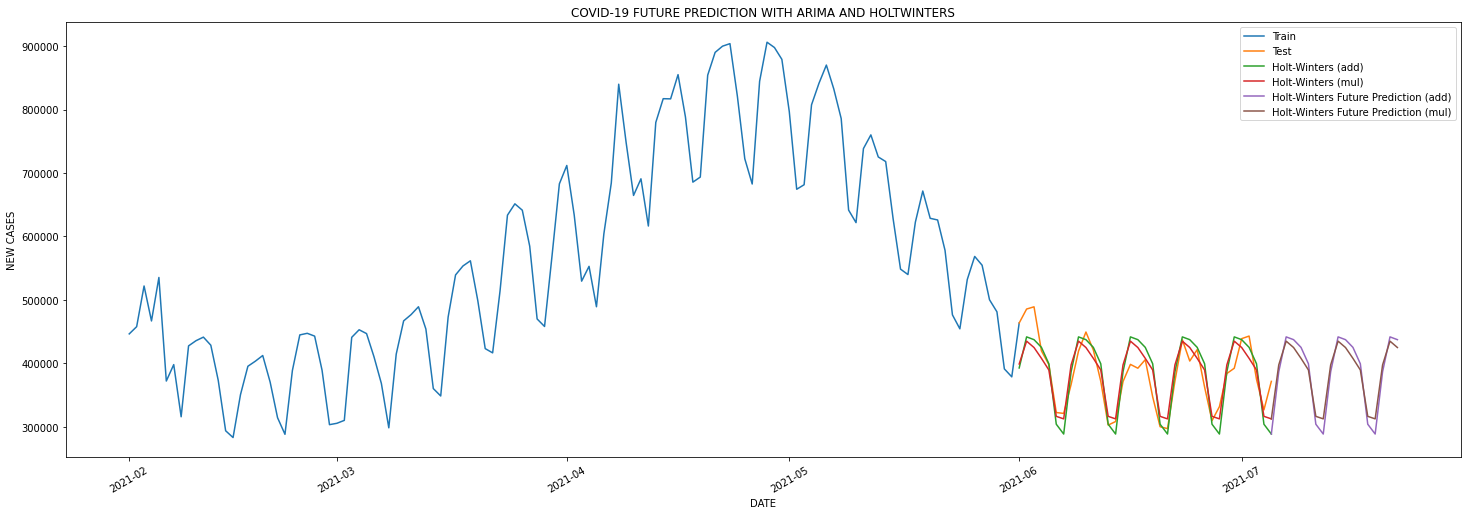

In [ ]:
plt.figure(figsize=(25,8))
plt.title("COVID-19 FUTURE PREDICTION WITH ARIMA AND HOLTWINTERS")
plt.plot(train_World.index, train_World, label='Train')
plt.plot(test_World.index, test_World, label='Test')
plt.plot(pred_add_World.index, pred_add_World - mae_World_add_hw,  label='Holt-Winters (add)')
plt.plot(pred_mul_World.index, pred_mul_World - mae_World_mul_hw,  label='Holt-Winters (mul)')
plt.plot(pred_next_N_days_add_World.index, pred_next_N_days_add_World.values - mae_World_add_hw, label="Holt-Winters Future Prediction (add)")
plt.plot(pred_next_N_days_mul_World.index, pred_next_N_days_mul_World.values - mae_World_mul_hw, label="Holt-Winters Future Prediction (mul)")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend(loc="best")
plt.xticks(rotation=30)
plt.show()

## Country Selection

In [ ]:
#SELECT CONTRY & Time 
country = "Japan"

#Select Time to train
start_time_ctr = '2021-02-01'
end_time_ctr = '2021-06-01'
# start_time->end_time (train),  End_time -> now (test)

In [ ]:
new_cases_ctr = df["new_cases"].where(df["location"] == country).dropna()
new_cases_ctr_smoothed = df["new_cases_smoothed"].where(df["location"] == country).dropna()

In [ ]:
train_ctr = new_cases_ctr.loc[start_time_ctr:end_time_ctr]  # train & test split
test_ctr = new_cases_ctr.loc[end_time_ctr:]

print("Train length: ", len(train_ctr))
print("Test length: ",len(test_ctr))
print("Ratio: ", (len(test_ctr))/ (len(test_ctr)+len(train_ctr)))  

Train length:  121
Test length:  36
Ratio:  0.22929936305732485


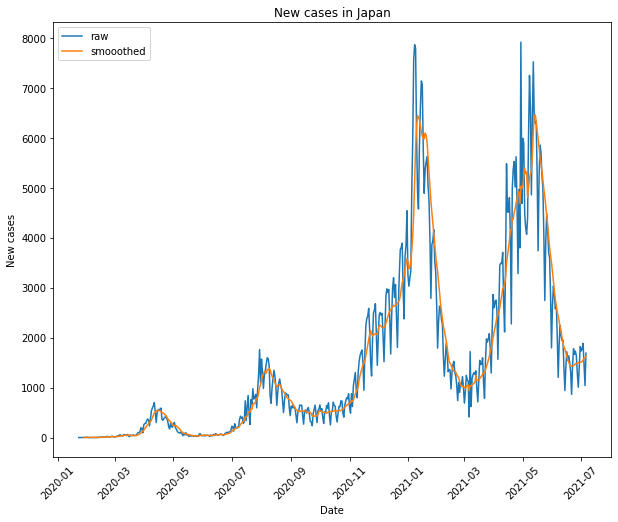

In [ ]:
plt.figure(figsize=(10,8))
plt.title("New cases in " + country)
plt.plot(new_cases_ctr, label="raw")
plt.plot(new_cases_ctr_smoothed, label="smooothed")
plt.xlabel('Date')
plt.ylabel('New cases')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
result_mul_ctr = seasonal_decompose(new_cases_ctr[start_time_ctr:], model='multiplicative')    
result_add_ctr = seasonal_decompose(new_cases_ctr[start_time_ctr:], model='additional')

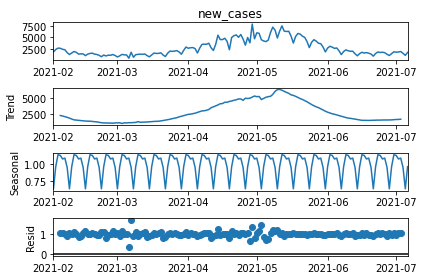

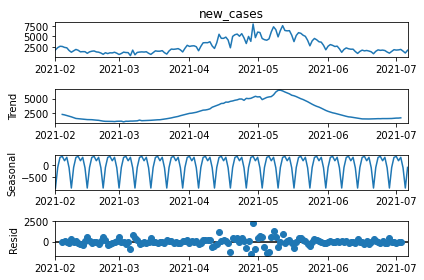

In [ ]:
result_mul_ctr.plot()
result_add_ctr.plot()
plt.show()

### ARIMA

In [ ]:
stepwise_model_ctr = auto_arima(new_cases_ctr[start_time_ctr:], m=7, seasonal=True,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)
print(stepwise_model_ctr.aic())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2445.206, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2520.005, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2459.454, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2462.382, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2518.008, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2462.850, Time=0.51 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=2448.559, Time=0.53 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=2446.053, Time=1.13 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=2444.127, Time=1.10 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=2458.639, Time=0.89 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=2446.788, Time=1.27 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=2446.809, Time=1.20 sec
 ARIMA(2,1,3)(1,0,2)[7] intercept   : AIC=2

In [ ]:
stepwise_model_ctr.fit(train_ctr)

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 2, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
future_forcast_ctr = stepwise_model_ctr.predict(n_periods=len(test_ctr)) 
future_forcast_ctr_dataframe = pd.DataFrame(future_forcast_ctr, index= test_ctr.index, columns=['Prediction'])
future_forcast_ctr_dataframe.head()

,Prediction
date,
2021-06-01,3248.897889
2021-06-02,3242.609346
2021-06-03,2987.139112
2021-06-04,3097.706421
2021-06-05,2612.345308


In [ ]:
mae_ctr_arima = mean_absolute_error(test_ctr, future_forcast_ctr_dataframe[0:len(test_ctr)])
mse_ctr_arima = mean_squared_error(test_ctr, future_forcast_ctr_dataframe[0:len(test_ctr)])
print("Mean absolute error: ", mae_ctr_arima)
print("Mean squared error: ", mse_ctr_arima)
print("Root mean squared error: ", np.sqrt(mse_ctr_arima))

Mean absolute error:  1007.5899358915285
Mean squared error:  1244292.1955682118
Root mean squared error:  1115.4784603784208


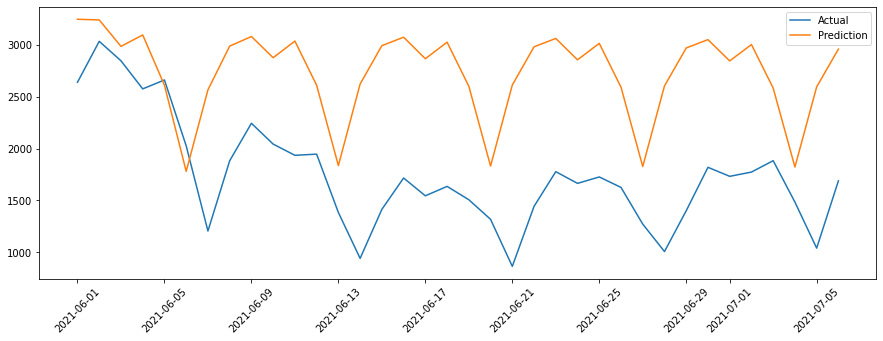

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_ctr, label="Actual")
plt.plot(future_forcast_ctr_dataframe, label="Prediction")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
test_ctr.index[-1]  # current day

Timestamp('2021-07-06 00:00:00')

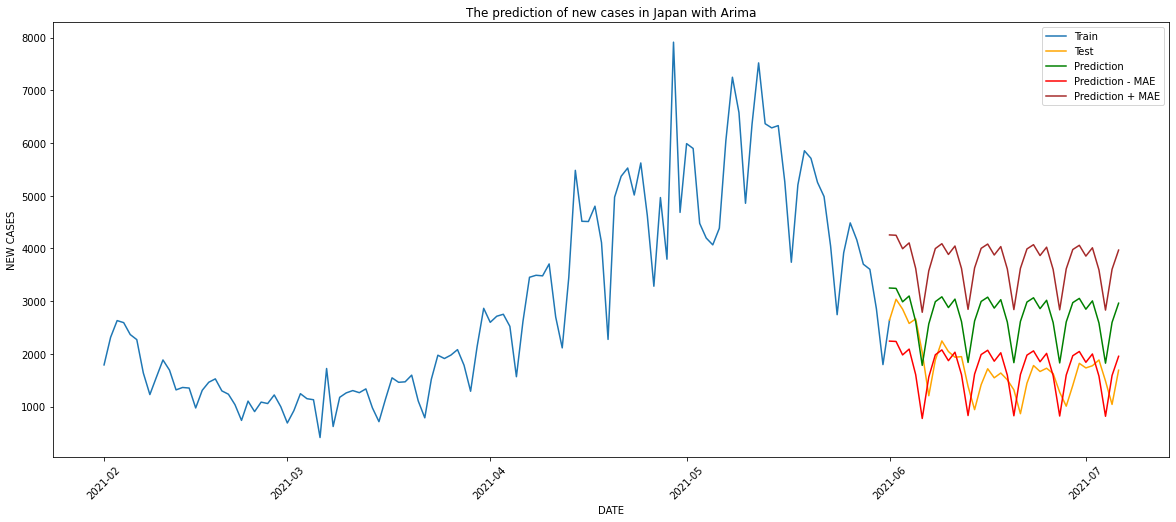

In [ ]:
plt.figure(figsize=(20,8))
plt.title("The prediction of new cases in " + country + " with Arima")
plt.plot(new_cases_ctr[start_time_ctr:end_time_ctr], label="Train")
plt.plot(new_cases_ctr[end_time_ctr:], label="Test", color="orange")
plt.plot(future_forcast_ctr_dataframe, label="Prediction", color="green")
plt.plot(future_forcast_ctr_dataframe - mae_ctr_arima, label="Prediction - MAE", color="red")
plt.plot(future_forcast_ctr_dataframe + mae_ctr_arima, label="Prediction + MAE", color="brown")
#plt.plot(pred_N_days_Arima - mae_ctr_arima, label="Future Prediction", color="brown")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Holt Winters

In [ ]:
HoltWinter_model_add = ExponentialSmoothing(train_ctr, seasonal='add', seasonal_periods=7).fit()
pred_add = HoltWinter_model_add.predict(start=test_ctr.index[0], end= test_ctr.index[-1])

HoltWinter_model_mul = ExponentialSmoothing(train_ctr, seasonal='mul', seasonal_periods=7).fit()
pred_mul = HoltWinter_model_mul.predict(start=test_ctr.index[0], end= test_ctr.index[-1])

In [ ]:
mae_ctr_add_hw = mean_absolute_error(test_ctr, pred_add[0:len(test_ctr)])
mse_ctr_add_hw = mean_squared_error(test_ctr, pred_add[0:len(test_ctr)])
print("MAE (add): ", mae_ctr_add_hw)
print("MSE (add): ", mse_ctr_add_hw)
mae_ctr_mul_hw = mean_absolute_error(test_ctr, pred_mul[0:len(test_ctr)])
mse_ctr_mul_hw = mean_squared_error(test_ctr, pred_mul[0:len(test_ctr)])
print("MAE (mul): ", mae_ctr_mul_hw)
print("MSE (mul): ",mse_ctr_mul_hw)

MAE (add):  1253.731826707626
MSE (add):  1781366.4594611586
MAE (mul):  1148.143760839647
MSE (mul):  1479558.6053176562


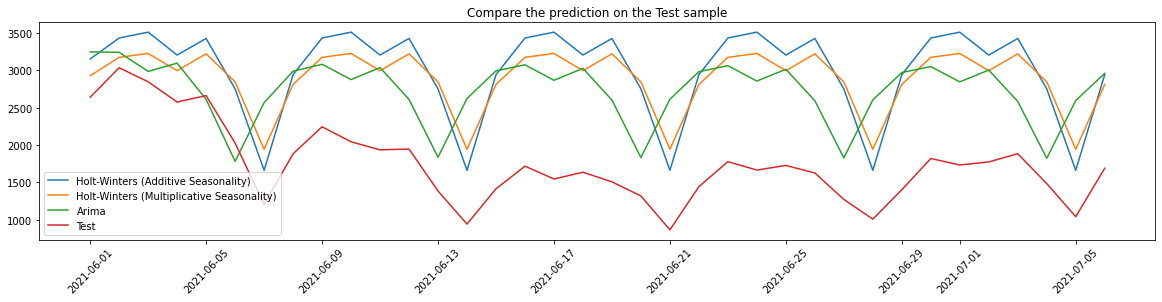

In [ ]:
plt.figure(figsize=(20,4))
plt.title("Compare the prediction on the Test sample")
plt.plot(pred_add, label="Holt-Winters (Additive Seasonality) ")
plt.plot(pred_mul, label="Holt-Winters (Multiplicative Seasonality)")
plt.plot(future_forcast_ctr_dataframe, label="Arima")
plt.plot(new_cases_ctr[end_time_ctr:], label="Test")
plt.legend(loc="best")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Future Prediction

In [ ]:
test_ctr.index[-1]  # current day

Timestamp('2021-07-06 00:00:00')

In [ ]:
# SELECT TIME TO PREDICT
start_time_ = datetime.datetime(2021,7, 7) 
end_time_ = datetime.datetime(2021, 7, 30)  

In [ ]:
pred_next_N_days_add = HoltWinter_model_add.predict(start=start_time_, end=end_time_)
pred_next_N_days_mul = HoltWinter_model_mul.predict(start=start_time_, end=end_time_)
pred_N_add = pd.Series(pred_next_N_days_add)
pred_N_mul = pd.Series(pred_next_N_days_mul)

In [ ]:
start_end_index = pd.date_range(start=start_time_,end=end_time_)
pred_next_N_days_Arima = stepwise_model_ctr.predict(len(start_end_index))
pred_N_days_Arima = pd.DataFrame(pred_next_N_days_Arima, index= start_end_index, columns=['Prediction'])

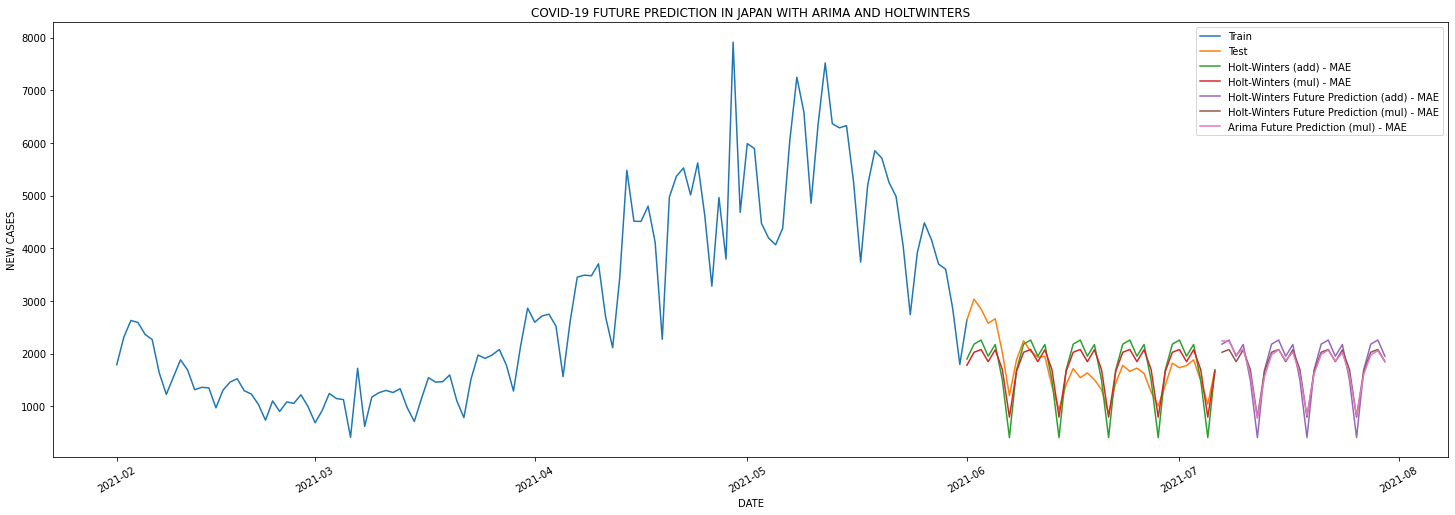

In [ ]:
plt.figure(figsize=(25,8))
plt.title("COVID-19 FUTURE PREDICTION IN " + country.upper() + " WITH ARIMA AND HOLTWINTERS")
plt.plot(train_ctr.index, train_ctr, label='Train')
plt.plot(test_ctr.index, test_ctr, label='Test')
plt.plot(pred_add.index, pred_add - mae_ctr_add_hw,  label='Holt-Winters (add) - MAE')
plt.plot(pred_mul.index, pred_mul - mae_ctr_mul_hw,  label='Holt-Winters (mul) - MAE')
plt.plot(pred_next_N_days_add.index, pred_next_N_days_add.values - mae_ctr_add_hw , label="Holt-Winters Future Prediction (add) - MAE")
plt.plot(pred_next_N_days_mul.index, pred_next_N_days_mul.values - mae_ctr_mul_hw, label="Holt-Winters Future Prediction (mul) - MAE")
#plt.plot(future_forcast_ctr_dataframe, label="Arima")
plt.plot(pred_N_days_Arima - mae_ctr_arima, label="Arima Future Prediction (mul) - MAE")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend(loc="best")
plt.xticks(rotation=30)
plt.savefig("South_Korea.png")
plt.show()

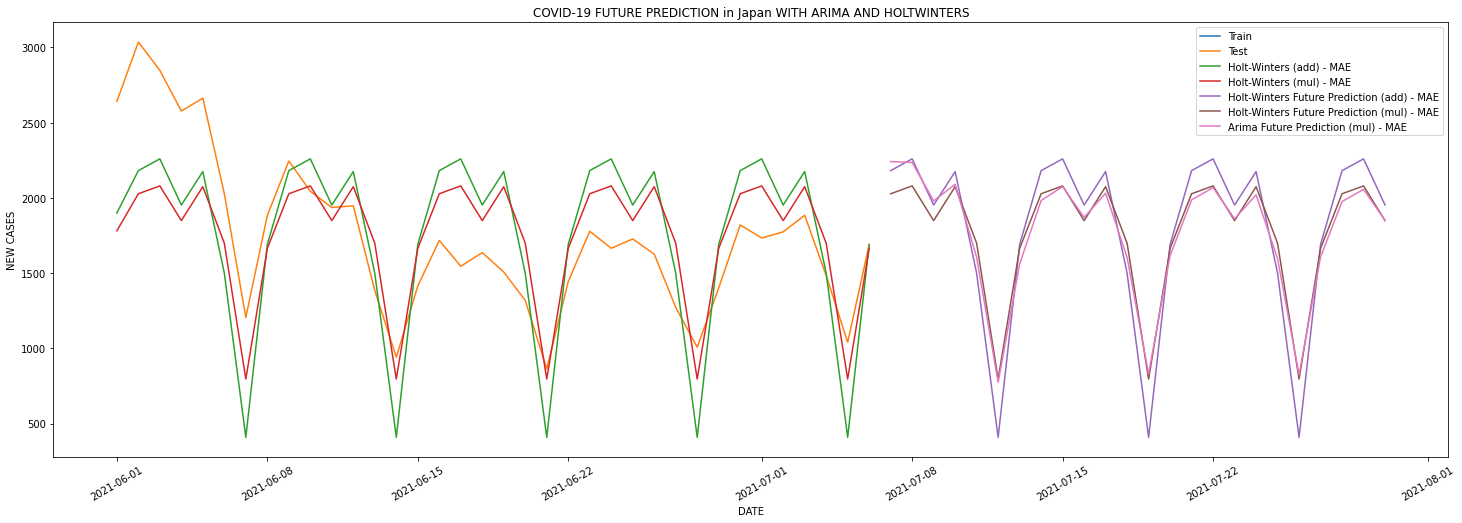

In [ ]:
plt.figure(figsize=(25,8))
plt.title("COVID-19 FUTURE PREDICTION in " + country + " WITH ARIMA AND HOLTWINTERS")
plt.plot(train_ctr['2021-06-01':], label='Train')
plt.plot(test_ctr.index, test_ctr, label='Test')
plt.plot(pred_add.index, pred_add - mae_ctr_add_hw,  label='Holt-Winters (add) - MAE')
plt.plot(pred_mul.index, pred_mul - mae_ctr_mul_hw,  label='Holt-Winters (mul) - MAE')
plt.plot(pred_next_N_days_add.index, pred_next_N_days_add.values - mae_ctr_add_hw , label="Holt-Winters Future Prediction (add) - MAE")
plt.plot(pred_next_N_days_mul.index, pred_next_N_days_mul.values  - mae_ctr_mul_hw, label="Holt-Winters Future Prediction (mul) - MAE")
#plt.plot(future_forcast_ctr_dataframe + mae_ctr_arima, label="Arima")
plt.plot(pred_N_days_Arima - mae_ctr_arima, label="Arima Future Prediction (mul) - MAE")
plt.xlabel("DATE")
plt.ylabel("NEW CASES")
plt.legend(loc="best")
plt.xticks(rotation=30)
plt.savefig("South_Korea_crop" + ".png")
plt.show()

In [ ]:
country + "_crop" + ".png"

'Japan_crop.png'

#Cross Country Example